# Goal of this notebook

To analyze and visualize the data from Kaggle.
No feature creation here.

In [1]:
import sys
sys.path.append('../code/')
sys.path.append('../src/')


# Import for data handling
import numpy as np
import pandas as pd
import networkx as nx

# Machine Learning imports
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from giotto.homology import VietorisRipsPersistence
from features.features import *



# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
from visualization.plotting import plot_diagram, plot_betti_curves



# Other imports
from tqdm import tqdm
from itertools import product
import os, random
from joblib import Parallel, delayed


%matplotlib inline

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Data Import and Overview

In [2]:
file_folder = '../data/champs-scalar-coupling' if 'champs-scalar-coupling' in os.listdir('../data/') else '../data'
os.listdir(file_folder)

['.DS_Store',
 '.gitkeep',
 '__init__.py',
 '.ipynb_checkpoints',
 'processed',
 'raw']

In [3]:
train = pd.read_csv(f'{file_folder}/raw/train.csv')
test = pd.read_csv(f'{file_folder}/raw/test.csv')
sub = pd.read_csv(f'{file_folder}/raw/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/raw/structures.csv')
contributions = pd.read_csv((f'{file_folder}/raw/scalar_coupling_contributions.csv'))

In [4]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [5]:
# top 100 molecules with the most number of (i.e. samples in the dataset) 
def get_number_of_atoms(g):
    return len(g)
train.groupby(by='molecule_name').apply(get_number_of_atoms).nlargest(100).sum()

12609

In [6]:
print('Number of different structures:', len(structures))
structures.head()

Number of different structures: 2358657


,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [7]:
contributions.head()

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.0224,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.0325,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.0319,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.0222,0.254585,1.25861,0.272013


In [8]:
print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {structures['atom'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 5 unique atoms.
There are 8 unique types.


In [9]:
from IPython.display import display, HTML
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

print('Length of train set:', len(train))
print('Unique molecules in train set:', np.unique(train['molecule_name'].to_numpy()).shape[0])
print('Unique molecules in test set:', np.unique(test['molecule_name'].to_numpy()).shape[0])
display(train.describe())
display(train.head())

Length of train set: 4658147
Unique molecules in train set: 85003
Unique molecules in test set: 45772


,id,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,2.329073e+06,1.335689e+01,5.883966e+00,1.592165e+01
std,1.344691e+06,3.267712e+00,4.993943e+00,3.494198e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.621860e+01
25%,1.164536e+06,1.100000e+01,2.000000e+00,-2.549780e-01
50%,2.329073e+06,1.300000e+01,5.000000e+00,2.281130e+00
75%,3.493610e+06,1.600000e+01,8.000000e+00,7.390655e+00
max,4.658146e+06,2.800000e+01,2.800000e+01,2.048800e+02


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


/Users/colinkalin/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



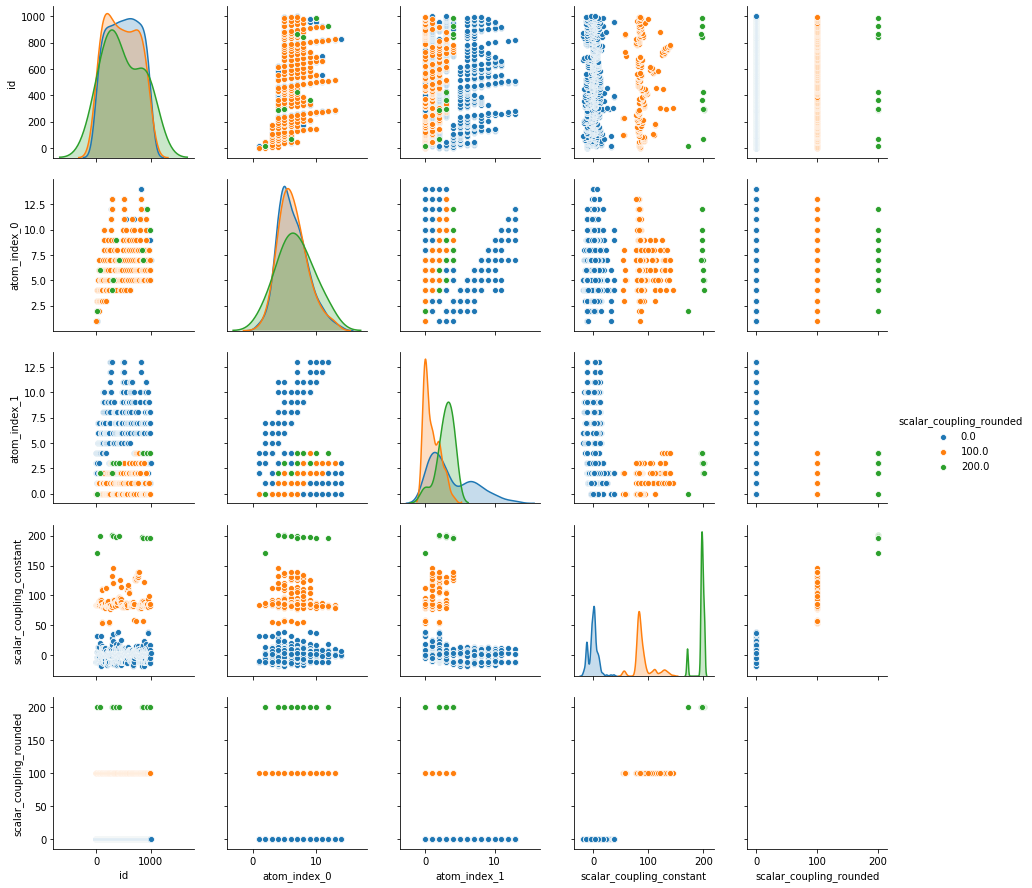

In [10]:
train_plot = train.copy()
train_plot['scalar_coupling_rounded'] = np.abs(np.around(train_plot['scalar_coupling_constant'], -2))
sns.pairplot(train_plot.head(1000), hue='scalar_coupling_rounded')

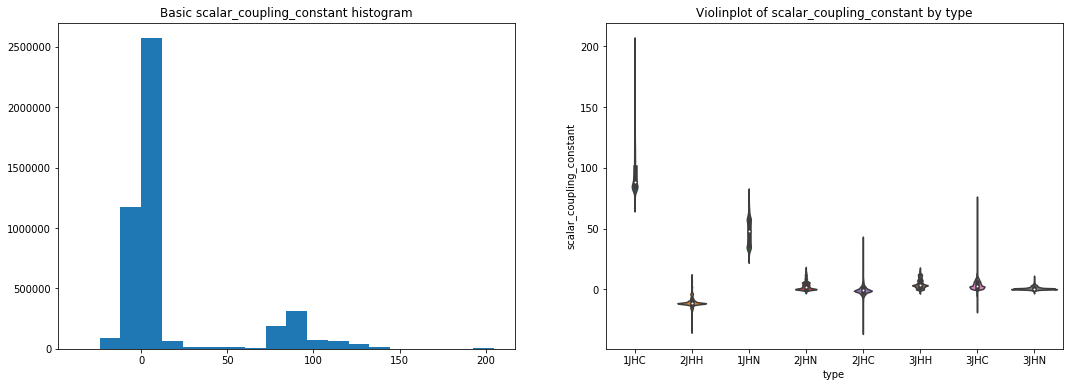

In [11]:
fig, ax = plt.subplots(figsize = (18, 6))
plt.subplot(1, 2, 1);
plt.hist(train['scalar_coupling_constant'], bins=20);
plt.title('Basic scalar_coupling_constant histogram');
plt.subplot(1, 2, 2);
sns.violinplot(x='type', y='scalar_coupling_constant', data=train);
plt.title('Violinplot of scalar_coupling_constant by type');

/Users/colinkalin/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



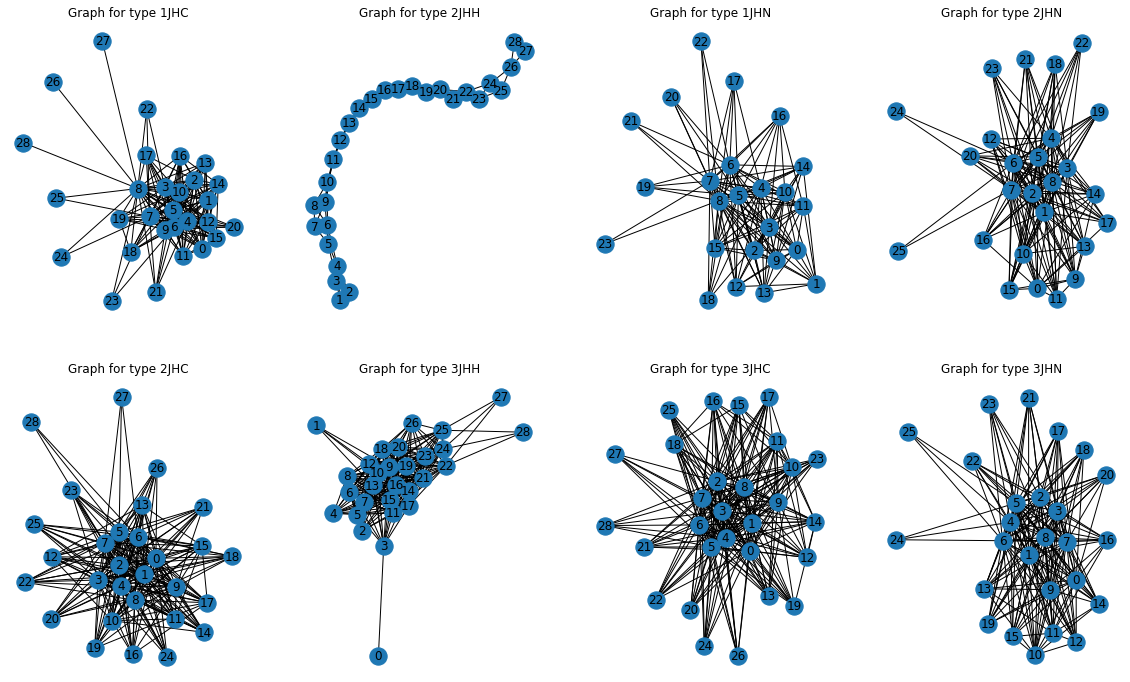

In [12]:
fig, ax = plt.subplots(figsize = (20, 12))
for i, t in enumerate(train['type'].unique()):
    train_type = train.loc[train['type'] == t]
    G = nx.from_pandas_edgelist(train_type, 'atom_index_0', 'atom_index_1', ['scalar_coupling_constant'])
    plt.subplot(2, 4, i + 1);
    nx.draw(G, with_labels=True);
    plt.title(f'Graph for type {t}')

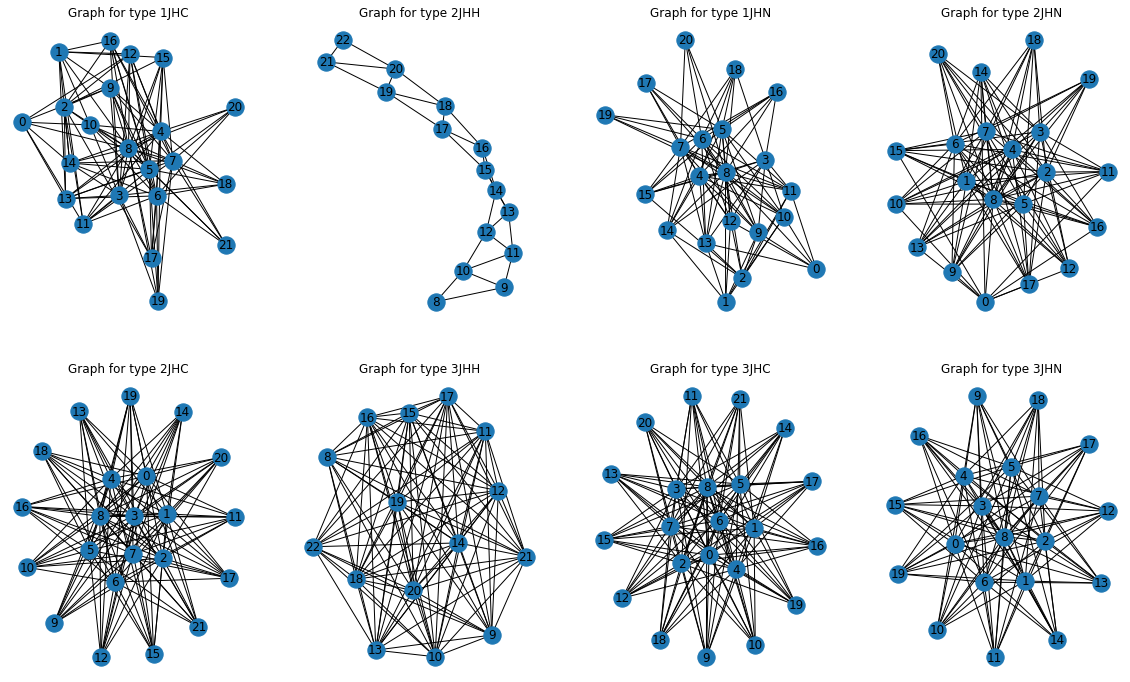

In [13]:
fig, ax = plt.subplots(figsize = (20, 12)) 
graphs = []
for i, t in enumerate(train['type'].unique()):
    train_type = train.loc[train['type'] == t]
    bad_atoms_0 = list(train_type['atom_index_0'].value_counts(normalize=True)[train_type['atom_index_0'].value_counts(normalize=True) < 0.01].index)
    bad_atoms_1 = list(train_type['atom_index_1'].value_counts(normalize=True)[train_type['atom_index_1'].value_counts(normalize=True) < 0.01].index)
    bad_atoms = list(set(bad_atoms_0 + bad_atoms_1))
    train_type = train_type.loc[(train_type['atom_index_0'].isin(bad_atoms_0) == False) & (train_type['atom_index_1'].isin(bad_atoms_1) == False)]
    G = nx.from_pandas_edgelist(train_type, 'atom_index_0', 'atom_index_1', ['scalar_coupling_constant'])
    plt.subplot(2, 4, i + 1);
    nx.draw(G, with_labels=True);
    plt.title(f'Graph for type {t}')  
    graphs.append(G)

In [16]:
plot_diagram(computing_persistence_diagram(graphs[1])[0])

[[0. 1. 1. 2. 2. 3. 3. 4. 4. 5. 5. 6. 6. 7. 7.]
 [1. 0. 1. 1. 2. 2. 3. 3. 4. 4. 5. 5. 6. 6. 7.]
 [1. 1. 0. 1. 1. 2. 2. 3. 3. 4. 4. 5. 5. 6. 6.]
 [2. 1. 1. 0. 1. 1. 2. 2. 3. 3. 4. 4. 5. 5. 6.]
 [2. 2. 1. 1. 0. 1. 1. 2. 2. 3. 3. 4. 4. 5. 5.]
 [3. 2. 2. 1. 1. 0. 1. 1. 2. 2. 3. 3. 4. 4. 5.]
 [3. 3. 2. 2. 1. 1. 0. 1. 1. 2. 2. 3. 3. 4. 4.]
 [4. 3. 3. 2. 2. 1. 1. 0. 1. 1. 2. 2. 3. 3. 4.]
 [4. 4. 3. 3. 2. 2. 1. 1. 0. 1. 1. 2. 2. 3. 3.]
 [5. 4. 4. 3. 3. 2. 2. 1. 1. 0. 1. 1. 2. 2. 3.]
 [5. 5. 4. 4. 3. 3. 2. 2. 1. 1. 0. 1. 1. 2. 2.]
 [6. 5. 5. 4. 4. 3. 3. 2. 2. 1. 1. 0. 1. 1. 2.]
 [6. 6. 5. 5. 4. 4. 3. 3. 2. 2. 1. 1. 0. 1. 1.]
 [7. 6. 6. 5. 5. 4. 4. 3. 3. 2. 2. 1. 1. 0. 1.]
 [7. 7. 6. 6. 5. 5. 4. 4. 3. 3. 2. 2. 1. 1. 0.]]


In [ ]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])
train['type_1'] = train['type'].apply(lambda x: x[1:])
test['type_1'] = test['type'].apply(lambda x: x[1:])

In [ ]:
print()
sns.scatterplot(data=train, y='scalar_coupling_constant', x='type')

In [ ]:
def add_mean_per_group(g):
    return np.mean(g)

train_ = train.merge(pd.DataFrame(train.groupby('type')['scalar_coupling_constant']
                         .apply(add_mean_per_group))
                         .rename({'scalar_coupling_constant':'scalar_coupling_mean'}, axis='columns'), on='type')

In [ ]:
max_number_samples = 10000
idx_sample = random.sample(range(len(train)), max_number_samples)

## Graphs

In [ ]:
name = 'dsgdb9nsd_133882'

def get_bonds(molecule_name, structures):
    """Generates a set of bonds from atomic cartesian coordinates"""
    atomic_radii = dict(C=0.77, F=0.71, H=0.38, N=0.75, O=0.73)  #Source: https://en.wikipedia.org/wiki/Atomic_radii_of_the_elements_(data_page)
    cpk_colors = dict(C='black', F='green', H='white', N='blue', O='red')
    
    molecule = structures[structures.molecule_name == molecule_name]
    coordinates = molecule[['x', 'y', 'z']].values
    x_coordinates = coordinates[:, 0]
    y_coordinates = coordinates[:, 1]
    z_coordinates = coordinates[:, 2]
    elements = molecule.atom.tolist()
    radii = [atomic_radii[element] for element in elements]
    ids = np.arange(coordinates.shape[0])
    bonds = dict()
    coordinates_compare, radii_compare, ids_compare = coordinates, radii, ids

    for _ in range(len(ids)):
        coordinates_compare = np.roll(coordinates_compare, -1, axis=0)
        radii_compare = np.roll(radii_compare, -1, axis=0)
        ids_compare = np.roll(ids_compare, -1, axis=0)
        distances = np.linalg.norm(coordinates - coordinates_compare, axis=1)
        bond_distances = (radii + radii_compare) * 1.3
        mask = np.logical_and(distances > 0.1, distances <  bond_distances)
        distances = distances.round(2)
        new_bonds = {frozenset([i, j]): dist for i, j, dist in zip(ids[mask], ids_compare[mask], distances[mask])}
        bonds.update(new_bonds)
        bonds_list = [list(x) for x in list(bonds)]
        bond_df = pd.DataFrame(bonds_list, columns=['source', 'target']) 
        bond_df['type_source'] = [molecule[molecule['atom_index']==a_idx]['atom'].values[0] for a_idx in bond_df['source'].values]
        bond_df['type_target'] = [molecule[molecule['atom_index']==a_idx]['atom'].values[0] for a_idx in bond_df['target'].values]

    return bond_df 

In [ ]:
bonds = get_bonds(name, structures)

def get_weight(bonds):
    def access_weight_dict(pair):
        weight_dict = {'HC': 94.976153,
                       'CH': 94.976153,
                       'HN': 47.479884,
                       'NC': 47.479884,
                       'CN': 100,
                       'NC': 100, 
                       'CC': 100}
        if pair in weight_dict.keys():
            return weight_dict[pair]
        else:
            return 100
    source = bonds['type_source'].values
    target = bonds['type_target'].values
    return [access_weight_dict(pair[0]+pair[1]) for pair in zip(source, target)]
    

bonds['weight'] = get_weight(bonds)

In [ ]:
G = nx.Graph()
for index, e in bonds.iterrows():
    G.add_edge(e['source'], e['target'], weight=e['weight'])

In [ ]:
train.head()

# Local Features

In [ ]:
# Import classical features

# top 100 molecules with the most number of atoms
def get_number_of_atoms(g):
    return len(g)
molecule_selection = train.groupby(by='molecule_name').apply(get_number_of_atoms).nlargest(100).index 


train_dist = pd.read_csv('../data/processed/train_dist.csv')

X = train_dist[train_dist['molecule_name'].isin(molecule_selection)].reset_index()
y = X['scalar_coupling_constant']
molecules = X['molecule_name'].values
#X.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis='columns', inplace=True)

lenc = LabelEncoder()
lenc.fit(X['atom_1'])
X['atom_0'] = lenc.transform(X['atom_0'])
X['atom_1'] = lenc.transform(X['atom_1'])

X.drop('index', axis='columns', inplace=True)

In [ ]:
X.head()

In [ ]:
structures[structures['molecule_name']=='dsgdb9nsd_036928']

In [ ]:
X.iloc[0][['atom_index_0', 'atom_index_1', 'molecule_name']]

In [ ]:
structures[(structures['molecule_name']=='dsgdb9nsd_036928') & (structures['atom_index']==9)]

In [ ]:
pers_diag_list = []
for mat in molecule_selection:   
    bonds = get_bonds(mat, structures)
    edges = pd.DataFrame(bonds, columns=['source', 'target'])
    graph = nx.from_pandas_edgelist(edges, source='source', target='target')
    pers_diag_list.append(computing_persistence_diagram(graph))